In [5]:
!pip install --upgrade numpy pandas


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
file_path = "train_FD001.txt"
column_names = ["unit_number", "time_in_cycles", "operational_setting_1", "operational_setting_2", 
                "operational_setting_3"] + [f"sensor_{i}" for i in range(1, 22)]

df = pd.read_csv(file_path, sep=" ", header=None, names=column_names, engine="python")

# Remove empty columns due to extra spaces in the file
df = df.dropna(axis=1, how='all')

# Drop non-sensor columns
sensor_data = df.iloc[:, 5:]

# Standardize sensor readings
scaler = StandardScaler()
normalized_data = scaler.fit_transform(sensor_data)

# Apply PCA for feature extraction (retain 95% variance)
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(normalized_data)

# Convert back to DataFrame
processed_df = pd.DataFrame(pca_data)

# Save preprocessed data
processed_df.to_csv("preprocessed_train_FD001.csv", index=False)

print("Preprocessing complete. Data saved as 'preprocessed_train_FD001.csv'")

Preprocessing complete. Data saved as 'preprocessed_train_FD001.csv'


In [3]:
!pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/204.1 MB 10.1 MB/s eta 0:00:21
    --------------------------------------- 2.6/204.1 MB 6.3 MB/s eta 0:00:33
   - -------------------------------------- 5.2/204.1 MB 8.2 MB/s eta 0:00:25
   - -------------------------------------- 5.2/204.1 MB 8.2 MB/s eta 0:00:25
   - -------------------------------------- 7.6/204.1 MB 7.2 MB/s eta 0:00:28
   -- ------------------------------------- 10.2/204.1 MB 8.1 MB/s eta 0:00:25
   -- ------------------------------------- 12.6/204.1 MB 8.6 MB/s eta 0:00:23
   -- ------------------------------------- 13.6/204.1 MB 8.7 MB/s eta 0:00:22
   --- ------------------------------------ 15.5/204.1 MB 8.2 MB/s eta 0:00:23
   --- ------------------------------------ 17.3/204.1 MB 8.3 MB/s eta 0:00:23
   --- ------------------------------------ 19.7/204.1 MB 8.6 MB/s eta 0:00:22
   ---- ----------------------------------- 21.0/204.1 MB 8.6 MB

In [4]:
# Wasserstein GAN for Improved Synthetic Data Generation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Load and preprocess real data
real_data = pd.read_csv("train_FD001_converted.csv")
sensor_columns = ['sensor_1', 'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21']
real_data = real_data[sensor_columns]
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_data)

tensor_data = torch.tensor(real_scaled, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(tensor_data), batch_size=64, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, z):
        return self.model(z)

# Critic (WGAN uses Critic instead of Discriminator)
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.model(x)

# Initialize models
latent_dim = 10
input_dim = real_scaled.shape[1]
generator = Generator(latent_dim, input_dim)
critic = Critic(input_dim)

# Optimizers
lr = 0.00005
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

# Training parameters
epochs = 1000
n_critic = 5
clip_value = 0.01

# Training loop
for epoch in range(epochs):
    for i, (real_batch,) in enumerate(dataloader):
        batch_size = real_batch.size(0)

        # Train critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z).detach()

            loss_C = -torch.mean(critic(real_batch)) + torch.mean(critic(fake_data))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

            # Weight clipping
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Train generator
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        loss_G = -torch.mean(critic(fake_data))

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Critic Loss = {loss_C.item():.4f}, Generator Loss = {loss_G.item():.4f}")

# Generate synthetic data
generator.eval()
with torch.no_grad():
    z = torch.randn(len(real_data), latent_dim)
    synthetic_scaled = generator(z).numpy()
    synthetic_data = scaler.inverse_transform(synthetic_scaled)

# Save synthetic data
synthetic_df = pd.DataFrame(synthetic_data, columns=sensor_columns)
os.makedirs("output", exist_ok=True)
synthetic_df.to_csv("output/wgan_synthetic_train_FD001.csv", index=False)
print("✅ Synthetic data generated using WGAN and saved to 'output/wgan_synthetic_train_FD001.csv'")


Epoch 0: Critic Loss = -0.0100, Generator Loss = -0.0304
Epoch 100: Critic Loss = 0.0010, Generator Loss = -0.0031
Epoch 200: Critic Loss = -0.0008, Generator Loss = -0.0065
Epoch 300: Critic Loss = -0.0052, Generator Loss = -0.0186
Epoch 400: Critic Loss = 0.0017, Generator Loss = -0.0345
Epoch 500: Critic Loss = -0.0117, Generator Loss = -0.0260
Epoch 600: Critic Loss = -0.0077, Generator Loss = 0.0240
Epoch 700: Critic Loss = -0.0104, Generator Loss = -0.0314
Epoch 800: Critic Loss = -0.0021, Generator Loss = -0.0288
Epoch 900: Critic Loss = 0.0267, Generator Loss = -0.0366
✅ Synthetic data generated using WGAN and saved to 'output/wgan_synthetic_train_FD001.csv'


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Fake example for demo purposes
N = 1000
sensor_values = torch.randn(N, 1)                       # Real values
sensor_indices = torch.randint(0, 21, (N,))             # Sensor label per sample (0 to 20)
sensor_onehot = F.one_hot(sensor_indices, num_classes=21).float()

# Dataset with both values and one-hot conditions
dataset = TensorDataset(sensor_values, sensor_onehot)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load datasets
real_data = pd.read_csv("train_FD001_converted.csv")
synthetic_data = pd.read_csv("output/wgan_synthetic_train_FD001.csv")

# Confirm column names
print("Real Data Columns:", real_data.columns.tolist())
print("Synthetic Data Columns Before Renaming:", synthetic_data.columns.tolist())


# Confirm after renaming
print("Renamed Synthetic Columns:", synthetic_data.columns.tolist())

# Define sensors to compare
sensor_columns = ['sensor_1', 'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21']
real_data = real_data[sensor_columns]
real_subset = real_data[sensor_columns]
synthetic_subset = synthetic_data[sensor_columns]

# Create output folder
output_dir = "sensor_validation_plots"
os.makedirs(output_dir, exist_ok=True)

# Store validation metrics
results = []

# Loop through each sensor and compare
for sensor in sensor_columns:
    if sensor in real_subset.columns and sensor in synthetic_subset.columns:
        real_values = real_subset[sensor].dropna()
        synthetic_values = synthetic_subset[sensor].dropna()

        # Truncate to match length
        min_len = min(len(real_values), len(synthetic_values))
        real_values = real_values[:min_len]
        synthetic_values = synthetic_values[:min_len]

        # Statistical tests
        ks_stat, ks_p = ks_2samp(real_values, synthetic_values)
        w_dist = wasserstein_distance(real_values, synthetic_values)
        anon_score = 1 - np.mean(np.abs(real_values - synthetic_values) / (np.std(real_values) + 1e-6))

        results.append({
            "Sensor": sensor,
            "KS Test Statistic": ks_stat,
            "KS P-Value": ks_p,
            "Wasserstein Distance": w_dist,
            "Anonymity Score": anon_score
        })

        # Plot distributions
        plt.figure(figsize=(8, 4))
        sns.kdeplot(real_values, label="Real Data", fill=True)
        sns.kdeplot(synthetic_values, label="Synthetic Data", fill=True)
        plt.title(f"Distribution Comparison - {sensor}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/dist_comparison_{sensor}.png")
        plt.close()

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("synthetic_data_validation_results.csv", index=False)

# Output summary
print("\n Validation complete. Results saved to 'synthetic_data_validation_results.csv'")
print("Distribution plots saved in 'sensor_validation_plots/' folder")
print("\n Summary of Results:")
print(results_df)



Real Data Columns: ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
Synthetic Data Columns Before Renaming: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
Renamed Synthetic Columns: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


C:\Users\arkha\AppData\Local\Temp\ipykernel_2320\2727142904.py:59: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(real_values, label="Real Data", fill=True)
C:\Users\arkha\AppData\Local\Temp\ipykernel_2320\2727142904.py:59: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(real_values, label="Real Data", fill=True)



 Validation complete. Results saved to 'synthetic_data_validation_results.csv'
Distribution plots saved in 'sensor_validation_plots/' folder

 Summary of Results:
       Sensor  KS Test Statistic     KS P-Value  Wasserstein Distance  \
0    sensor_1           0.524357   0.000000e+00              0.016633   
1    sensor_2           0.059134   8.452257e-32              0.055216   
2    sensor_3           0.034511   4.134817e-11              0.460972   
3    sensor_4           0.034172   6.690684e-11              0.742737   
4    sensor_5           0.701178   0.000000e+00              0.018873   
5    sensor_6           0.559159   0.000000e+00              0.000346   
6    sensor_7           0.042170   2.233057e-16              0.092312   
7    sensor_8           0.046483   8.277854e-20              0.006045   
8    sensor_9           0.043818   1.195793e-17              1.651562   
9   sensor_10           0.615966   0.000000e+00              0.017156   
10  sensor_11           0.035432 

In [7]:
import pandas as pd

# Load the CSV
csv_path = "train_FD001_converted.csv"  # Update path if needed
df = pd.read_csv(csv_path, header=None)

# Define column names
column_names = (
    ['unit', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] +
    [f'sensor_{i}' for i in range(1, 22)]
)
df.columns = column_names

# Drop any rows with NaNs (just in case the first row is empty)
df.dropna(inplace=True)

# Ensure all values are numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Calculate RUL
rul_df = df.groupby('unit')['time'].max().reset_index()
rul_df.columns = ['unit', 'max_time']
df = df.merge(rul_df, on='unit', how='left')
df['RUL'] = df['max_time'] - df['time']
df.drop('max_time', axis=1, inplace=True)

# Preview the result
print(df.head())

# Optional: Save to a new file
df.to_csv("train_FD001_final_preprocessed.csv", index=False)


   unit  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   NaN   NaN           NaN           NaN           NaN       NaN       NaN   
1   1.0   1.0       -0.0007       -0.0004         100.0    518.67    641.82   
2   1.0   2.0        0.0019       -0.0003         100.0    518.67    642.15   
3   1.0   3.0       -0.0043        0.0003         100.0    518.67    642.35   
4   1.0   4.0        0.0007        0.0000         100.0    518.67    642.35   

   sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  sensor_15  \
0       NaN       NaN       NaN  ...        NaN        NaN        NaN   
1   1589.70   1400.60     14.62  ...    2388.02    8138.62     8.4195   
2   1591.82   1403.14     14.62  ...    2388.07    8131.49     8.4318   
3   1587.99   1404.20     14.62  ...    2388.03    8133.23     8.4178   
4   1582.79   1401.87     14.62  ...    2388.08    8133.83     8.3682   

   sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21    RUL  
0        

In [9]:
# Load real data
real_data = pd.read_csv("preprocessed_train_FD001.csv")

# Print all column names
print(real_data.columns.tolist())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
import pandas as pd
import numpy as np

# Load real and synthetic data
real_data = pd.read_csv("train_FD001_final_preprocessed.csv")
synthetic_data = pd.read_csv("final_synthetic_data.csv")

# Optional: Drop columns that are not sensor-based (e.g., 'unit', 'time', 'RUL' or 'rul')
sensor_columns = [col for col in real_data.columns if col.startswith("sensor_")]
synthetic_data = synthetic_data[sensor_columns]  # assume only sensor data is needed

# Estimate real-data standard deviations for each sensor
real_std = real_data[sensor_columns].std()

# Define noise level as a percentage of real data std (e.g., 10%)
noise_factor = 0.1  # you can change this to 0.05 for subtle noise

# Add noise to synthetic data
noisy_synthetic = synthetic_data.copy()
for col in sensor_columns:
    noise = np.random.normal(loc=0.0, scale=noise_factor * real_std[col], size=len(noisy_synthetic))
    noisy_synthetic[col] += noise

# Optional: Add back other columns if needed
# For example, regenerate 'unit', 'time', 'rul'
noisy_synthetic['unit'] = 1
noisy_synthetic['time'] = np.arange(1, len(noisy_synthetic) + 1)
noisy_synthetic['rul'] = np.linspace(150, 0, num=len(noisy_synthetic))

# Reorder columns
cols = ['unit', 'time'] + sensor_columns + ['rul']
noisy_synthetic = noisy_synthetic[cols]

# Save to file
noisy_synthetic.to_csv("output/noisy_synthetic_data.csv", index=False)
print(" Noisy synthetic data saved to 'output/noisy_synthetic_data.csv'")


 Noisy synthetic data saved to 'output/noisy_synthetic_data.csv'



Linear Regression Results:
  RMSE: 44.16
  R² Score: 0.57


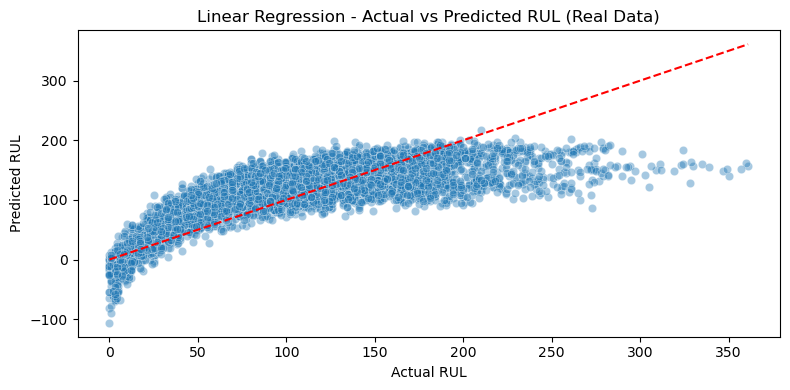


Random Forest Results:
  RMSE: 41.59
  R² Score: 0.62


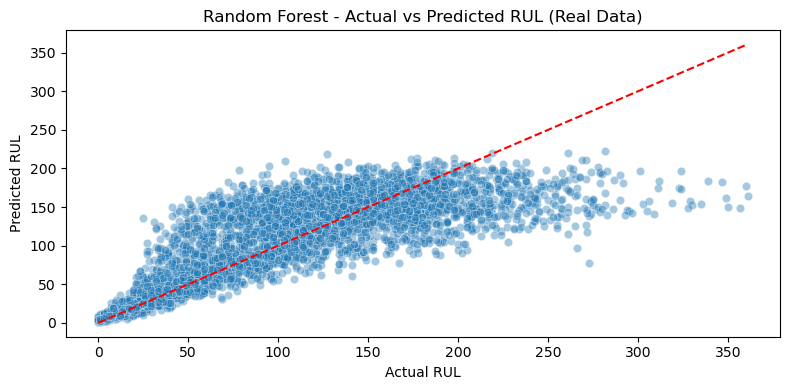

In [13]:
# ML Models for Predicting RUL from Real C-MAPSS FD001 Data

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Ensure output directory exists
os.makedirs("output", exist_ok=True)

# Load preprocessed real dataset
real_data = pd.read_csv("train_FD001_final_preprocessed.csv")  # Update path if needed

# Drop unnecessary columns
X = real_data.drop(columns=['unit', 'time', 'RUL'], errors='ignore')
y = real_data['RUL']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Enhanced evaluation function with NaN handling
def evaluate_model(name, y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Remove NaNs
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    cleaned_y_true = y_true[mask]
    cleaned_y_pred = y_pred[mask]

    if len(cleaned_y_true) == 0:
        print(f"\n{name} Evaluation Skipped: All values are NaN")
        return

    print(f"\n{name} Results:")
    print(f"  RMSE: {np.sqrt(mean_squared_error(cleaned_y_true, cleaned_y_pred)):.2f}")
    print(f"  R² Score: {r2_score(cleaned_y_true, cleaned_y_pred):.2f}")

    # Plot predictions
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=cleaned_y_true, y=cleaned_y_pred, alpha=0.4)
    plt.plot([cleaned_y_true.min(), cleaned_y_true.max()],
             [cleaned_y_true.min(), cleaned_y_true.max()], 'r--')
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"{name} - Actual vs Predicted RUL (Real Data)")
    plt.tight_layout()
    plt.savefig(f"output/{name.lower().replace(' ', '_')}_rul_real_prediction.png")
    plt.show()

# Evaluate both models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


In [14]:
!pip install --user tensorflow


   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.6/376.0 MB 9.3 MB/s eta 0:00:41
   ---------------------------------------- 3.9/376.0 MB 9.8 MB/s eta 0:00:39
   ---------------------------------------- 4.2/376.0 MB 10.1 MB/s eta 0:00:37
    --------------------------------------- 5.2/376.0 MB 6.9 MB/s eta 0:00:54
    --------------------------------------- 5.8/376.0 MB 6.1 MB/s eta 0:01:01
    --------------------------------------- 6.3/376.0 MB 5.1 MB/s eta 0:01:12
    --------------------------------------- 6.8/376.0 MB 4.8 MB/s eta 0:01:17
    --------------------------------------- 7.6/376.0 MB 4.7 MB/s eta 0:01:20
    --------------------------------------- 8.7/376.0 MB 4.6 MB/s eta 0:01:21
   - -------------------------------------- 9.7/376.0 MB 4.6 MB/s eta 0:01:19
   - -------------------------------------- 10.7/376.0 MB 4.8 MB/s eta 0:01:17
   - -------------------------------------- 12.1/376.0 MB 4.9 MB/s et

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
# Enhanced RUL Pipeline with Fine-Tuning and Feature Importance Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

os.makedirs("output", exist_ok=True)

# Load and prepare real data
real = pd.read_csv("train_FD001_preprocessed.csv")
sensor_cols = [col for col in real.columns if col.startswith("sensor_")]
X_real = real[sensor_cols].copy()
y_real = real['RUL']

X_real = X_real.rolling(window=5, min_periods=1).mean()
X_real['sensor_5_11'] = X_real['sensor_5'] * X_real['sensor_11']

real_clean = pd.concat([X_real, y_real], axis=1).dropna(subset=['RUL'])
X_real = real_clean.drop(columns='RUL')
y_real = real_clean['RUL']

# Load and enhance synthetic data
synthetic = pd.read_csv("output/wgan_synthetic_train_FD001.csv")
n_engines = 10
engine_length = len(synthetic) // n_engines
synthetic = synthetic.iloc[:n_engines * engine_length].copy()
synthetic['unit'] = np.repeat(range(1, n_engines + 1), engine_length)
synthetic['time'] = synthetic.groupby('unit').cumcount() + 1
synthetic['sensor_2'] = np.linspace(600, 400, len(synthetic)) + np.random.normal(0, 10, len(synthetic))
synthetic['sensor_5'] = np.linspace(100, 70, len(synthetic)) + np.random.normal(0, 3, len(synthetic))
synthetic['sensor_11'] = 130 + 10 * np.sin(np.linspace(0, 10, len(synthetic))) + np.random.normal(0, 5, len(synthetic))
synthetic['rul'] = (
    0.3 * synthetic['sensor_2'] +
    0.5 * synthetic['sensor_5'] +
    0.2 * np.sin(synthetic['sensor_11']) +
    np.random.normal(0, 15, len(synthetic)) +
    np.random.uniform(-5, 5, len(synthetic))
)

X_syn = synthetic[sensor_cols].copy()
X_syn['sensor_5_11'] = X_syn['sensor_5'] * X_syn['sensor_11']
y_syn = synthetic['rul']

# Impute and scale
imputer = SimpleImputer(strategy='mean')
X_real = pd.DataFrame(imputer.fit_transform(X_real), columns=X_real.columns)
X_syn = pd.DataFrame(imputer.transform(X_syn), columns=X_syn.columns)
scaler = StandardScaler()
X_real_scaled = pd.DataFrame(scaler.fit_transform(X_real), columns=X_real.columns)
X_syn_scaled = pd.DataFrame(scaler.transform(X_syn), columns=X_syn.columns)

# Train/test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real_scaled, y_real, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn_scaled, y_syn, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": HistGradientBoostingRegressor(random_state=42)
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, dataset):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mask = ~np.isnan(y_test) & ~np.isnan(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
    r2 = r2_score(y_test[mask], y_pred[mask])
    print(f"{dataset} | {name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R² Score: {r2:.2f}\n")

print("\n--- Real Data Performance ---")
for name, model in models.items():
    evaluate_model(name, model, Xr_train, yr_train, Xr_test, yr_test, "Real")

print("\n--- Synthetic Data Performance ---")
for name, model in models.items():
    evaluate_model(name, model, Xs_train, ys_train, Xs_test, ys_test, "Synthetic")

# Fine-tuning: Pretrain on synthetic, fine-tune on real subset
print("\n--- Fine-Tuned on Combined Data ---")
X_combined = pd.concat([X_syn_scaled, Xr_train])
y_combined = pd.concat([y_syn, yr_train])
fine_tune_model = RandomForestRegressor(n_estimators=100, random_state=42)
fine_tune_model.fit(X_combined, y_combined)
y_pred_ft = fine_tune_model.predict(Xr_test)
rmse_ft = np.sqrt(mean_squared_error(yr_test, y_pred_ft))
r2_ft = r2_score(yr_test, y_pred_ft)
print(f"Fine-Tuned RF | RMSE: {rmse_ft:.2f}, R²: {r2_ft:.2f}\n")

def plot_feature_importance(model, X, y, features, title, filename):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()


plot_feature_importance(models["Random Forest"], X_real, y_real, X_real.columns, "Real Data Feature Importance (RF)", "real_rf_importance.png")
plot_feature_importance(models["Gradient Boosting"], X_real, y_real, X_real.columns, "Real Data Feature Importance (GB)", "real_gb_importance.png")
plot_feature_importance(fine_tune_model, X_real, y_real, X_real.columns, "Fine-Tuned RF Feature Importance", "fine_tuned_rf_importance.png")


--- Real Data Performance ---
Real | Linear Regression:
  RMSE: 48.11
  R² Score: 0.49

Real | Random Forest:
  RMSE: 39.94
  R² Score: 0.65

Real | Gradient Boosting:
  RMSE: 42.09
  R² Score: 0.61


--- Synthetic Data Performance ---
Synthetic | Linear Regression:
  RMSE: 14.99
  R² Score: 0.67

Synthetic | Random Forest:
  RMSE: 15.24
  R² Score: 0.66

Synthetic | Gradient Boosting:
  RMSE: 15.07
  R² Score: 0.67


--- Fine-Tuned on Combined Data ---
Fine-Tuned RF | RMSE: 39.91, R²: 0.65

